# Setup

This project requires Python 3.7+.

In [ ]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn 1.0.1+.

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Get the Data

Now that we have the setup complete, we need to import the data. The following function checks if the data is stored locally. If not, it will download it from a repository. Finally, the function returns the data as a Pandas DataFrame for the sake of convenience.

In [ ]:
from pathlib import Path
import pandas as pd
from scipy.io import arff
import tarfile
import urllib.request

def load_dataset():
    file_path = Path("dataset_31_credit-g.arff")
    if not file_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://www.openml.org/data/download/31/dataset_31_credit-g.arff"
        urllib.request.urlretrieve(url, file_path)
    arff_file = arff.loadarff(file_path)

    return pd.DataFrame(arff_file[0])

default_dataset = load_dataset ()

Now that we have the data, we can take a quick look at it's structure.

In [ ]:
default_dataset.head ()

It looks like the strings aren't formatted correctly. This is likely because they are byte strings, which are not handled by Scipy by default. We can fix this by iterating over the data and decoding any byte strings we find.

In [ ]:
default_dataset = default_dataset.map(lambda x: x.decode() if isinstance(x, bytes) else x)

In [ ]:
default_dataset.head ()

Great! Looks like our data is in order now. Let's take a look at all the columns and their datatypes.

In [ ]:
default_dataset.info ()

In [ ]:
default_dataset.describe ()

In [ ]:
object_columns = default_dataset.select_dtypes(include=['object'])

for column in object_columns:
    print (default_dataset[column].value_counts())
    print ()

It looks like there are many non-numerical columns that we'll need to handle later. Thankfully, they all seem to be categorical columns, so we can handle them similarly to how we did in Project 1. It also looks like non of the columns are missing values, which means we won't have to assume/impute anything this time.

It also seems like the class column contains the labels we need to train the model.

Just like in Project 1, we need to split our data into train/test sets. We also need to keep the output consistent (even if the code is run multiple times) and stratified (so the samples represent the population). For this, we've split the labels and data, and then we feed them into train_test_split () with a constant seed and a train set size of 20%. This produces separate predictor/target value pairs for the train/test sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_dataset = default_dataset.drop('class', axis=1) # Predictors
y_dataset = default_dataset['class'] # Labels
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2, stratify=y_dataset, random_state=42)

We can confirm that the stratified sampling worked by looking at the value counts for each target value set. We can also set normalize=True to see the proportion of values rather than a count.

In [ ]:
print("Original class distribution:")
print(y_dataset.value_counts(normalize=True))
print(y_dataset.value_counts())
print ()

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())
print ()

print("Test set class distribution:")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

As we can see, the data has been stratified quite nicely!

# Discover and Visualize the Data to Gain Insights

In order to create an effective model, we must first understand the data so we can look for patterns ourselves. Let's start by generating some graphs for the numerical columns.

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

default_dataset.hist(bins=50, figsize=(10, 6))
plt.show()

This makes it clear that some of the numerical columns are skewed. We can also generate a scatter matrix to see how each column is correlated with each other.

In [ ]:
from pandas.plotting import scatter_matrix

# Finds all numeric columns
numeric_column_names = []
numeric_columns = default_dataset.select_dtypes(include=['float64'])
for column in numeric_columns:
    numeric_column_names.append(column)

plt.rc('font', size=10)
plt.rc('axes', labelsize=8, titlesize=10)
scatter_matrix(default_dataset[numeric_column_names], figsize=(18, 12))
plt.subplots_adjust (wspace = 0.1, hspace = 0.1)
plt.show()

Let's try to see the correlation between the categorical columns too. We can do this by using an ordinal encoder to convert one into a numerical column.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
corr_dataset = default_dataset.copy()

for column in object_columns:
    corr_dataset[[column]] = ordinal_encoder.fit_transform(default_dataset[[column]])

class_column = default_dataset[['class']]
# ordinal_encoder = OrdinalEncoder()
# corr_dataset = default_dataset.drop('class', axis=1)
# class_column_encoded = ordinal_encoder.fit_transform(class_column)
# corr_dataset = default_dataset.copy()
# corr_dataset[['class']] = ordinal_encoder.fit_transform(default_dataset[['class']])

In [ ]:
corr_dataset.info ()

In [ ]:
# class_column_encoded[:8]
corr_dataset[['class']][:8]

In [ ]:
corr_dataset.dtypes["class"]

As you can see, all the columns are now numerical. Now we can use corr_dataset to check the correlation between columns. Since class is our label, let's start with that.

In [ ]:
corr_matrix = corr_dataset.corr(numeric_only=True)
corr_matrix["class"].sort_values(ascending=False)

It looks like none of the columns have a strong correlation with our label. Let's plot a matrix of correlations to get a better idea of our data's relationships.

In [ ]:
from pandas.plotting import scatter_matrix

# Finds all numeric columns
corr_numeric_column_names = []
corr_numeric_columns = corr_dataset.select_dtypes(include=['float64'])
for column in corr_numeric_columns:
    corr_numeric_column_names.append(column)

plt.rc('font', size=6)
plt.rc('axes', labelsize=6, titlesize=8)
scatter_matrix(corr_dataset, figsize=(18, 12))
plt.subplots_adjust (wspace = 0.1, hspace = 0.1)
plt.show()

It doesn't seem like there are any relationships that stick out here. Instead we can use the following function to find correlations above a certain threshold.

In [ ]:
# Prints correlation values for columns with correlation values above a threshold
# threshold is the absolute value of the minimum correlation you're looking for
def checkForCorrelation (threshold, corr_matrix, columns, only_show_above_threshold = False):
  assert threshold >= 0 and threshold <= 1

  # Check if correlation values in each column are above the threshold
  for column in columns:
    corr_values = corr_matrix[column].sort_values(ascending=False)
    if abs (corr_values.iloc[1]) > threshold or abs (corr_values.iloc[-1]) > threshold:
      print ("=====" + column + "=====")
      if only_show_above_threshold:
        print (corr_values[abs(corr_values) > threshold])
      else:
        print(corr_values)
      print ()

In [ ]:
checkForCorrelation (0.5, corr_matrix, corr_numeric_column_names, True)

It seems like only a couple of columns show any significant correlation. We will need to do some feature engineering to help the model understand the data better. Some ratio features such as monthly_credit_burden, installment_per_credit, dependents_per_credit might be more useful to the model.

**Feature engineering suggestions from AI:**


*   Bin age column into groups
*   Bin credit_amount
*   Create categories for duration
* Extract separate features for marital status and gender from person_status column
*   Use ordinal encoding for categorical columns whose categories are related in terms of order (like property magnitude)
*   Use one hot encoding for the other categorical columns
*   Create a new feature to represent the ratio of credit_amount to income
*   Create a combination of savings_status and credit_amount
*   Average duration of previous credits
*   Create time-based features if possible, like time since last credit or the month/season the application was made
*   Develop risk ratios for good/bad applicants



# Prepare the Data

First, let's make a copy of the training set and labels.

In [ ]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

Now we can start cleaning the the data by constructing a pipeline of transformers. This will also give us an chance to implement some of our feature engineering ideas too. First, we should define some helper functions that will compute ratio features that  may be more helpful to the model. For this, we can reuse some of our code from Project 1.

There are a couple major changes we need to make first though. The first change addresses a data incompatibility in the column_ratio () function. Now it uses the DataFrame syntax. The other change is that the ratio_pipeline () function now computes the log of the new column. This is to ensure that the new columns are not skewed.

In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
def column_ratio(X, columns):
    # print ((X[columns[0]] / X[columns[1]]).to_frame().head (5))
    return (X[columns[0]] / X[columns[1]]).to_frame()

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline(columns):
    print (columns)
    return make_pipeline(
        FunctionTransformer(lambda X: column_ratio (X, columns), feature_names_out=ratio_name),
        FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out="one-to-one"),
        StandardScaler())

Next, we need to convert our categorical columns into numerical columns. We will use ordinal encoding for columns whose categories are related to each other. This will allow the model to better see the relationship between the categories. We will also use ordinal encoding for binary categories, since they only have two values.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Defines the intended order of categories for each column
# This will ensure their relationships are preserved
ordered_categories = {
    "checking_status": ["no checking", "<0", "0<=X<200", ">=200"],
    "savings_status": ["no known savings", "<100", "100<=X<500", "500<=X<1000", ">=1000"],
    "employment": ["unemployed", "<1", "1<=X<4", "4<=X<7", ">=7"],
    "own_telephone": ["yes", "none"],
    # "foreign_worker": ["yes", "no"]
}

# Performs ordinal encoding with the provided category orders
class OrderedOrdinalEncoder(OrdinalEncoder):
    def fit(self, data, y=None):
        self.categories_ = [ordered_categories[column] for column in data.columns]
        return super().fit(data, y)

ordered_ordinal_encoder = OrderedOrdinalEncoder()

Now we should convert the rest of the columns. These ones don't have the same type of relationship between categories, so we'll use one-hot encoding instead.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_onehot_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

Now that the categorical pipelines have been defined, let's work on the numerical column pipelines. Most columns require computing their log (to fix their skew) and standardizing them (to make them easier for the model to understand).

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder

log_pipeline = make_pipeline(
    FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out="one-to-one"),
    StandardScaler())
default_num_pipeline = make_pipeline(StandardScaler())

Now we can wrap all our pipelines in  a ColumnTransformer to keep our code clean and provide an easy way to apply the transformers.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
ordinal_geo_pipeline = Pipeline([
    ('ordered_ordinal_encoder', ordered_ordinal_encoder),  # Assign a name to each step
    ('cluster_simil', cluster_simil),                    # Assign a name to each step
])

In [ ]:
# from sklearn.preprocessing import QuantileTransformer

# # Apply quantile transformation to the same columns you binned
# quantile_transformer = make_pipeline(
#     QuantileTransformer(output_distribution='uniform', random_state=42),
#     StandardScaler()  # Standardize the result after quantile transformation
# )

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures

# polynomial_pipeline = Pipeline([
#     ('poly', PolynomialFeatures(degree=2, include_bias=False))
# ])

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_selector

preprocessing = ColumnTransformer([
        ("monthly_credit_burden", ratio_pipeline(["credit_amount", "duration"]), ["credit_amount", "duration"]),
        ("installment_per_credit", ratio_pipeline(["installment_commitment", "credit_amount"]), ["installment_commitment", "credit_amount"]),
        ("dependents_per_credit", ratio_pipeline(["num_dependents", "credit_amount"]), ["num_dependents", "credit_amount"]),
        # ("age_to_existing_credits", ratio_pipeline(["age", "credit_amount"]), ["age", "credit_amount"]),
        # ("binning", quantile_transformer, ["age", "credit_amount", "duration"]),
        # ("polynomial", polynomial_pipeline, ["duration", "credit_amount", "age", "installment_commitment"]),
        ("log", log_pipeline, ["duration", "credit_amount", "installment_commitment",
                                "residence_since", "age", "existing_credits", "num_dependents"]),
        ("cat_ordinal", ordered_ordinal_encoder, list(ordered_categories.keys())),
        ("cat_onehot", cat_onehot_pipeline, ["job", "housing", "other_payment_plans",
                                "property_magnitude", "other_parties", "personal_status",
                                "credit_history"]),
        ("geo", ordinal_geo_pipeline, ["savings_status", "checking_status"]),
        ('drop_out', 'drop', ["num_dependents", "foreign_worker", "purpose"])
    ],
    remainder=default_num_pipeline)

With that done, the last part is simply running the training set through the transformers.

In [ ]:
X_train_prep = preprocessing.fit_transform(X_train_copy)

Once we have the new data, we can use a method to see what new columns it has generated.

In [ ]:
preprocessing.get_feature_names_out()

It's clear that the one-hot encoding added a lot of new columns, so we should keep that in mind later when we're choosing a model.

We can also convert the data from a Numpy array back to a DataFrame. This will make it easier to view the data again and generate graphs.

In [ ]:
X_train_prep_df = pd.DataFrame(X_train_prep, columns=preprocessing.get_feature_names_out())

In [ ]:
X_train_prep_df.info ()

In [ ]:
X_train_prep_df.describe ()

,monthly_credit_burden__ratio,installment_per_credit__ratio,dependents_per_credit__ratio,log__duration,log__credit_amount,log__installment_commitment,log__residence_since,log__age,log__existing_credits,log__num_dependents,...,geo__Cluster 0 similarity,geo__Cluster 1 similarity,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,geo__Cluster 5 similarity,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity
count,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,...,800.000000,800.000000,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,800.000000,800.000000,8.000000e+02,8.000000e+02
mean,-5.195844e-16,-1.720846e-16,-5.551115e-17,-5.928591e-16,-1.436629e-15,3.830269e-17,6.661338e-18,-1.643130e-16,1.088019e-16,1.576517e-16,...,0.301861,0.242608,1.194435e-01,7.206779e-02,6.712836e-02,6.342229e-02,0.236633,0.210484,1.363701e-01,1.480321e-01
std,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,1.000626e+00,...,0.395431,0.389909,2.997730e-01,2.048517e-01,2.105861e-01,2.088672e-01,0.347395,0.233344,2.282274e-01,2.158751e-01
min,-2.820775e+00,-3.025196e+00,-2.690702e+00,-2.530398e+00,-2.886549e+00,-2.107715e+00,-2.004683e+00,-1.752317e+00,-7.541061e-01,-4.425095e-01,...,0.000328,0.000002,2.521746e-11,3.266012e-10,1.331001e-10,2.948304e-11,0.000002,0.000335,2.606142e-08,2.493622e-08
25%,-7.385604e-01,-6.662208e-01,-6.693017e-01,-6.575752e-01,-7.331832e-01,-6.496691e-01,-5.372006e-01,-7.488095e-01,-7.541061e-01,-4.425095e-01,...,0.006810,0.000123,4.104263e-06,3.499898e-05,1.151916e-05,4.798507e-06,0.000123,0.006738,7.768799e-05,7.433383e-05
50%,-6.767474e-02,1.103665e-01,4.723493e-02,3.362790e-02,-5.658197e-02,2.032331e-01,3.212215e-01,-7.779471e-02,-7.541061e-01,-4.425095e-01,...,0.018315,0.018316,4.975913e-04,2.251829e-03,3.344317e-04,5.510880e-04,0.018316,0.135335,9.613104e-03,9.338486e-03
75%,6.718776e-01,7.711438e-01,6.526396e-01,5.240443e-01,6.445850e-01,8.083768e-01,9.302818e-01,6.480387e-01,1.159358e+00,-4.425095e-01,...,0.367869,0.367879,1.812930e-02,1.960769e-02,1.702192e-02,1.801705e-02,0.367879,0.367879,3.648516e-01,3.653336e-01
max,4.827774e+00,2.494270e+00,2.631514e+00,2.396867e+00,2.655598e+00,8.083768e-01,9.302818e-01,2.667450e+00,3.072821e+00,2.259839e+00,...,0.999971,1.000000,9.898261e-01,8.306351e-01,9.458139e-01,9.836978e-01,1.000000,1.000000,9.917696e-01,9.930796e-01


In [ ]:
X_train.head (5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
675,no checking,30.0,critical/other existing credit,radio/tv,4530.0,<100,4<=X<7,4.0,female div/dep/mar,none,4.0,car,26.0,none,rent,1.0,high qualif/self emp/mgmt,1.0,yes,yes
703,0<=X<200,30.0,delayed previously,business,2503.0,100<=X<500,>=7,4.0,male single,none,2.0,life insurance,41.0,stores,own,2.0,skilled,1.0,none,yes
12,0<=X<200,12.0,existing paid,radio/tv,1567.0,<100,1<=X<4,1.0,female div/dep/mar,none,1.0,car,22.0,none,own,1.0,skilled,1.0,yes,yes
845,0<=X<200,21.0,existing paid,furniture/equipment,3976.0,no known savings,4<=X<7,2.0,male single,none,3.0,car,35.0,none,own,1.0,skilled,1.0,yes,yes
795,no checking,9.0,existing paid,furniture/equipment,2301.0,100<=X<500,<1,2.0,female div/dep/mar,none,4.0,life insurance,22.0,none,rent,1.0,skilled,1.0,none,yes


In [ ]:
X_train_prep_df.head (5)

,monthly_credit_burden__ratio,installment_per_credit__ratio,dependents_per_credit__ratio,log__duration,log__credit_amount,log__installment_commitment,log__residence_since,log__age,log__existing_credits,log__num_dependents,...,geo__Cluster 0 similarity,geo__Cluster 1 similarity,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,geo__Cluster 5 similarity,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity
0,0.209324,-0.269834,-0.954237,0.904441,0.847377,0.808377,0.930282,-0.875008,-0.754106,-0.442509,...,0.018315,1.000000,1.812930e-02,3.499898e-05,1.151916e-05,1.801705e-02,0.000123,0.367879,3.648516e-01,3.653336e-01
1,-0.769248,0.316195,-0.219971,0.904441,0.082768,0.808377,-0.537201,0.648039,1.159358,-0.442509,...,0.006883,0.000002,2.521746e-11,2.156210e-07,9.458139e-01,2.619896e-04,0.018316,0.000335,7.768799e-05,2.493622e-08
2,-0.030305,-0.590627,0.359696,-0.657575,-0.520853,-2.107715,-2.004683,-1.433613,-0.754106,-0.442509,...,0.367869,0.000123,4.104263e-06,2.310620e-02,3.257759e-02,4.798507e-06,1.000000,0.018316,7.768799e-05,7.433383e-05
3,0.582502,-0.825704,-0.792779,0.296411,0.679247,-0.649669,0.321222,0.118960,-0.754106,-0.442509,...,0.006595,0.000002,2.240852e-04,8.306351e-01,3.764233e-07,2.948304e-11,0.018316,0.000335,2.606142e-08,7.433383e-05
4,1.077973,-0.285412,-0.115819,-1.147992,-0.025687,-0.649669,0.930282,-1.433613,-0.754106,-0.442509,...,0.000343,0.018316,1.113903e-07,3.266012e-10,3.344317e-04,9.836978e-01,0.000002,0.006738,3.648516e-01,1.225558e-04


Let's see what the data looks like now.

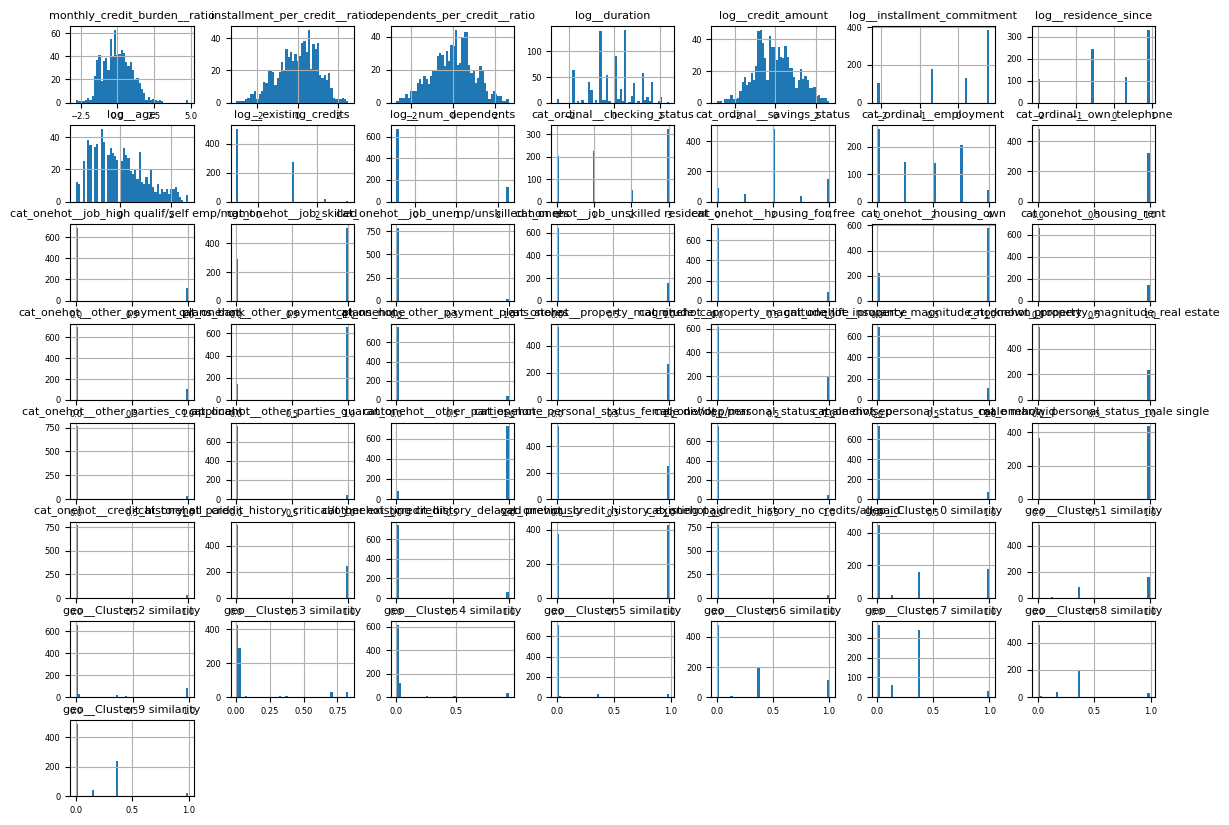

In [ ]:
plt.rc('font', size=8)
plt.rc('axes', labelsize=8, titlesize=8)
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=6)
plt.rc('ytick', labelsize=6)

X_train_prep_df.hist(bins=50, figsize=(14, 10))
plt.show()

Let's also check the correlation between the new columns.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

corr_train_prep_df = X_train_prep_df.copy()
corr_train_prep_df.insert (0, "class", le.fit_transform(y_train_copy.reset_index(drop=True)), True)

corr_train_prep_matrix = corr_train_prep_df.corr(numeric_only=True)

In [ ]:
checkForCorrelation (0.5, corr_train_prep_matrix, corr_train_prep_matrix.select_dtypes(include=['float64']), True)

=====monthly_credit_burden__ratio=====
monthly_credit_burden__ratio     1.000000
log__credit_amount               0.664788
dependents_per_credit__ratio    -0.603197
installment_per_credit__ratio   -0.737331
Name: monthly_credit_burden__ratio, dtype: float64

=====installment_per_credit__ratio=====
installment_per_credit__ratio    1.000000
dependents_per_credit__ratio     0.832216
log__installment_commitment      0.674063
monthly_credit_burden__ratio    -0.737331
log__credit_amount              -0.891710
Name: installment_per_credit__ratio, dtype: float64

=====dependents_per_credit__ratio=====
dependents_per_credit__ratio     1.000000
installment_per_credit__ratio    0.832216
monthly_credit_burden__ratio    -0.603197
log__duration                   -0.630935
log__credit_amount              -0.948341
Name: dependents_per_credit__ratio, dtype: float64

=====log__duration=====
log__duration                   1.000000
log__credit_amount              0.635610
dependents_per_credit__ratio   

In [ ]:
corr_train_prep_matrix["class"].sort_values(ascending=False)

,class
class,1.000000
cat_ordinal__checking_status,0.308926
geo__Cluster 9 similarity,0.264498
geo__Cluster 1 similarity,0.198765
geo__Cluster 8 similarity,0.196115
cat_onehot__credit_history_critical/other existing credit,0.187973
geo__Cluster 2 similarity,0.178445
geo__Cluster 5 similarity,0.124555
cat_onehot__other_payment_plans_none,0.123915
log__age,0.123420


# Model Selection

For model selection we are going to be experimenting with the following models:


1.   Logistic Regression
2.   Random Forest
3. Gradient Boosting
4. Support Vector Machine
5. Extreme Gradient Boosting
6. Stochastic Gradient Descent
7. Ensemble Method

Based on the following metrics we will be selecting a model for further evaluation and finetuining.



1.   Accuracy
2.   Precision
3.   Recall
4.   f1
5.   roc_auc
    


Based on current literature about the German Credit Risk dataset, we expect the Random Forest and Extreme GRadient Boosting models to perform the best.

# Model Training



### Logistic Regression

First we will be training a Logistic Regression model on the preprocessed data.

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

log_reg = make_pipeline(preprocessing, LogisticRegression(random_state=42, class_weight='balanced'))
log_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('monthly_credit_burden',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78a662f00dc0>,
                                                                                       func=<function ratio_pipeline.<locals>.<lambda> at 0x78a6624f3250>)),
                                                                  ('function...
                                                   'personal_status',
                                                   'credit_history']),
                                                 ('geo',
                                                  Pipeline(steps=[('ordered_ordinal_encoder',
                                                                   OrderedOrdinalEncoder()),
                                                                  ('cluster_simil',
                                                                   ClusterSimilarity(random_state=42))]),
                                                  ['savings_status',
                                                   'checking_status']),
                                                 ('drop_out', 'drop',
                                                  ['num_dependents',
                                                   'foreign_worker',
                                                   'purpose'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', random_state=42))])

Testing the accuracy of the model:

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
train_predictions = log_reg.predict(X_train)

# Evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, pos_label='good')
train_recall = recall_score(y_train, train_predictions, pos_label='good')
train_f1 = f1_score(y_train, train_predictions, pos_label='good')
train_roc_auc = roc_auc_score(y_train, log_reg.predict_proba(X_train)[:, 1])

# Print training set results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print("-" * 30)

Training Set Performance:
Accuracy: 0.7425
Precision: 0.8766
Recall: 0.7357
F1-Score: 0.8000
ROC-AUC: 0.8123
------------------------------


### Random Forest

We are now going to be training a random forest model.

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

random_forest = make_pipeline(preprocessing, RandomForestClassifier(random_state=42, class_weight='balanced'))
random_forest.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('monthly_credit_burden',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78a662f00dc0>,
                                                                                       func=<function ratio_pipeline.<locals>.<lambda> at 0x78a6624f3250>)),
                                                                  ('function...
                                                   'personal_status',
                                                   'credit_history']),
                                                 ('geo',
                                                  Pipeline(steps=[('ordered_ordinal_encoder',
                                                                   OrderedOrdinalEncoder()),
                                                                  ('cluster_simil',
                                                                   ClusterSimilarity(random_state=42))]),
                                                  ['savings_status',
                                                   'checking_status']),
                                                 ('drop_out', 'drop',
                                                  ['num_dependents',
                                                   'foreign_worker',
                                                   'purpose'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Testing the accuracy of the model:

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
train_predictions = random_forest.predict(X_train)

# Evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, pos_label='good')
train_recall = recall_score(y_train, train_predictions, pos_label='good')
train_f1 = f1_score(y_train, train_predictions, pos_label='good')
train_roc_auc = roc_auc_score(y_train, random_forest.predict_proba(X_train)[:, 1])

# Print training set results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print("-" * 30)

Training Set Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000
------------------------------


### Gradient Boosting

We are now going to be training a random forest model.

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

grad_boost = make_pipeline(preprocessing, GradientBoostingClassifier(random_state=42))
grad_boost.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('monthly_credit_burden',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78a662f00dc0>,
                                                                                       func=<function ratio_pipeline.<locals>.<lambda> at 0x78a6624f3250>)),
                                                                  ('function...
                                                   'personal_status',
                                                   'credit_history']),
                                                 ('geo',
                                                  Pipeline(steps=[('ordered_ordinal_encoder',
                                                                   OrderedOrdinalEncoder()),
                                                                  ('cluster_simil',
                                                                   ClusterSimilarity(random_state=42))]),
                                                  ['savings_status',
                                                   'checking_status']),
                                                 ('drop_out', 'drop',
                                                  ['num_dependents',
                                                   'foreign_worker',
                                                   'purpose'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

Testing the accuracy of the model:

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
train_predictions = grad_boost.predict(X_train)

# Evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, pos_label='good')
train_recall = recall_score(y_train, train_predictions, pos_label='good')
train_f1 = f1_score(y_train, train_predictions, pos_label='good')
train_roc_auc = roc_auc_score(y_train, grad_boost.predict_proba(X_train)[:, 1])

# Print training set results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print("-" * 30)

Training Set Performance:
Accuracy: 0.9250
Precision: 0.9153
Recall: 0.9839
F1-Score: 0.9484
ROC-AUC: 0.9743
------------------------------


### Support Vector Machine

We are now going to be training a random forest model.

In [84]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

svm_model = make_pipeline(preprocessing, SVC(random_state=42, probability=True, class_weight='balanced'))
svm_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('monthly_credit_burden',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78a662f00dc0>,
                                                                                       func=<function ratio_pipeline.<locals>.<lambda> at 0x78a6624f3250>)),
                                                                  ('function...
                                                   'other_parties',
                                                   'personal_status',
                                                   'credit_history']),
                                                 ('geo',
                                                  Pipeline(steps=[('ordered_ordinal_encoder',
                                                                   OrderedOrdinalEncoder()),
                                                                  ('cluster_simil',
                                                                   ClusterSimilarity(random_state=42))]),
                                                  ['savings_status',
                                                   'checking_status']),
                                                 ('drop_out', 'drop',
                                                  ['num_dependents',
                                                   'foreign_worker',
                                                   'purpose'])])),
                ('svc',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

Testing the accuracy of the model:

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
train_predictions = svm_model.predict(X_train)

# Evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, pos_label='good')
train_recall = recall_score(y_train, train_predictions, pos_label='good')
train_f1 = f1_score(y_train, train_predictions, pos_label='good')
train_roc_auc = roc_auc_score(y_train, svm_model.predict_proba(X_train)[:, 1])

# Print training set results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print("-" * 30)

Training Set Performance:
Accuracy: 0.7913
Precision: 0.9119
Recall: 0.7768
F1-Score: 0.8390
ROC-AUC: 0.8964
------------------------------


### Extreme Gradient Boosting

We are now going to be training a random forest model.

In [89]:
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
xgb_model = make_pipeline(preprocessing, XGBClassifier(random_state=42))
xgb_model.fit(X_train, y_train_encoded)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('monthly_credit_burden',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78a662f00dc0>,
                                                                                       func=<function ratio_pipeline.<locals>.<lambda> at 0x78a6624f3250>)),
                                                                  ('function...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [87]:
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'bad': 0, 'good': 1}


Testing the accuracy of the model:

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

train_predictions = xgb_model.predict(X_train)

train_accuracy = accuracy_score(y_train_encoded, train_predictions)
train_precision = precision_score(y_train_encoded, train_predictions)
train_recall = recall_score(y_train_encoded, train_predictions)
train_f1 = f1_score(y_train_encoded, train_predictions)
train_roc_auc = roc_auc_score(y_train_encoded, xgb_model.predict_proba(X_train)[:, 1])

print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print("-" * 30)


Training Set Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000
------------------------------


### Stochastic Gradient Descent

We are now going to be training a random forest model.

In [91]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

sgd_model = make_pipeline(preprocessing, SGDClassifier(random_state=42, loss='log_loss', penalty='elasticnet', learning_rate='optimal', class_weight='balanced'))
sgd_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('monthly_credit_burden',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78a662f00dc0>,
                                                                                       func=<function ratio_pipeline.<locals>.<lambda> at 0x78a6624f3250>)),
                                                                  ('function...
                                                   'credit_history']),
                                                 ('geo',
                                                  Pipeline(steps=[('ordered_ordinal_encoder',
                                                                   OrderedOrdinalEncoder()),
                                                                  ('cluster_simil',
                                                                   ClusterSimilarity(random_state=42))]),
                                                  ['savings_status',
                                                   'checking_status']),
                                                 ('drop_out', 'drop',
                                                  ['num_dependents',
                                                   'foreign_worker',
                                                   'purpose'])])),
                ('sgdclassifier',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               penalty='elasticnet', random_state=42))])

Testing the accuracy of the model:

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
train_predictions = sgd_model.predict(X_train)

# Evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, pos_label='good')
train_recall = recall_score(y_train, train_predictions, pos_label='good')
train_f1 = f1_score(y_train, train_predictions, pos_label='good')
train_roc_auc = roc_auc_score(y_train, sgd_model.predict_proba(X_train)[:, 1])

# Print training set results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print("-" * 30)

Training Set Performance:
Accuracy: 0.6850
Precision: 0.8548
Recall: 0.6625
F1-Score: 0.7465
ROC-AUC: 0.7771
------------------------------


### Ensemble Method

We are now going to be training a random forest model.

In [97]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Random Forest model
random_forest_em = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

# XGBoost model
xgboost = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Meta-learner (Logistic Regression to combine the outputs)
meta_learner = LogisticRegression(random_state=42)

# Create a stacking ensemble that uses Random Forest and XGBoost as base models
stacking_classifier = StackingClassifier(
    estimators=[
        ('random_forest', random_forest_em),
        ('xgboost', xgboost)
    ],
    final_estimator=meta_learner,
    passthrough=False  # Set to True if you want to pass original features alongside model predictions
)

# Full pipeline including preprocessing and stacking classifier
ensemble_model = Pipeline(steps=[
    ('preprocessing', preprocessing),  # Your custom preprocessing step goes here
    ('stacking', stacking_classifier)  # Stacking ensemble with RF and XGBoost
])

# Train the model
ensemble_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('monthly_credit_burden',
                                                  Pipeline(steps=[('functiontransformer-1',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x78a662f00dc0>,
                                                                                       func=<function ratio_pipeline.<locals>.<lambda> at 0x78a6624f3250>)),
                                                                  ('functiontran...
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...))],
                                    final_estimator=LogisticRegression(random_state=42)))])

Testing the accuracy of the model:

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
train_predictions = ensemble_model.predict(X_train)

# Evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions, pos_label='good')
train_recall = recall_score(y_train, train_predictions, pos_label='good')
train_f1 = f1_score(y_train, train_predictions, pos_label='good')
train_roc_auc = roc_auc_score(y_train, ensemble_model.predict_proba(X_train)[:, 1])

# Print training set results
print("Training Set Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")
print("-" * 30)

Training Set Performance:
Accuracy: 0.9988
Precision: 0.9982
Recall: 1.0000
F1-Score: 0.9991
ROC-AUC: 1.0000
------------------------------


# Model Evaluation

After training our models with Logistic Regression, Random Forest, Gradient Boosting, and SVM, we need to evaluate their performance on the testing data. We utiliz metrics such as accuracy, precision, recall, F1-score, and ROC-AUC to determine the model's effectiveness in predicting credit risk. Here's the code to evaluate the models:

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Function to evaluate the model's performance on the training set
def evaluate_model_on_train(model, X_train, y_train):
    # Make predictions on the training set
    y_pred = model.predict(X_train)

    # Calculate metrics using y_train for true labels
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, pos_label="good")
    recall = recall_score(y_train, y_pred, pos_label="good")
    f1 = f1_score(y_train, y_pred, pos_label="good")
    roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("\n")

# Logistic Regression Model
print("Logistic Regression Evaluation on Training Set:")
evaluate_model_on_train(log_reg, X_train, y_train)

# Random Forest Model
print("Random Forest Evaluation on Training Set:")
evaluate_model_on_train(random_forest, X_train, y_train)

# Gradient Boosting Model
print("Gradient Boosting Evaluation on Training Set:")
evaluate_model_on_train(grad_boost, X_train, y_train)

# SVM Model
print("SVM Evaluation on Training Set:")
evaluate_model_on_train(svm_model, X_train, y_train)

# Stochastic Gradient Descent
print("SGD Evaluation on Training Set:")
evaluate_model_on_train(sgd_model, X_train, y_train)

# Ensemble Method
print("Ensemble Method Evaluation on Training Set:")
evaluate_model_on_train(ensemble_model, X_train, y_train)


Logistic Regression Evaluation on Training Set:
Accuracy: 0.7425
Precision: 0.8766
Recall: 0.7357
F1-Score: 0.8000
ROC-AUC: 0.8123


Random Forest Evaluation on Training Set:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000


Gradient Boosting Evaluation on Training Set:
Accuracy: 0.9250
Precision: 0.9153
Recall: 0.9839
F1-Score: 0.9484
ROC-AUC: 0.9743


SVM Evaluation on Training Set:
Accuracy: 0.7913
Precision: 0.9119
Recall: 0.7768
F1-Score: 0.8390
ROC-AUC: 0.8964


SGD Evaluation on Training Set:
Accuracy: 0.6850
Precision: 0.8548
Recall: 0.6625
F1-Score: 0.7465
ROC-AUC: 0.7771


Ensemble Method Evaluation on Training Set:
Accuracy: 0.9988
Precision: 0.9982
Recall: 1.0000
F1-Score: 0.9991
ROC-AUC: 1.0000




Let's verify our results by checking the confusion matrices. The following code will use cross validation to predict some values and then compute a confusion matrix. This will help us better understand the errors each model is making.

In [109]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

# Function to calculate and return the confusion matrix
def getConfusionMatrix(model, X_train, y_train):
    y_pred = cross_val_predict(model, X_train, y_train, cv=3)
    return confusion_matrix(y_train, y_pred)

# Function to calculate accuracy, precision, and recall from confusion matrix
def calcStatsFromCM(conf_matrix):
    accuracy = (conf_matrix[0][0] + conf_matrix[1][1]) / (conf_matrix.sum())
    precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])
    recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])

    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    # Add F1 score if required

# Evaluate Logistic Regression
print("Logistic Regression Evaluation (Training Set):")
cf_toprint = getConfusionMatrix(log_reg, X_train, y_train)
print(cf_toprint)
calcStatsFromCM(cf_toprint)
print()

# Evaluate Random Forest
print("Random Forest Evaluation (Training Set):")
cf_toprint = getConfusionMatrix(random_forest, X_train, y_train)
print(cf_toprint)
calcStatsFromCM(cf_toprint)
print()

# Evaluate Gradient Boosting
print("Gradient Boosting Evaluation (Training Set):")
cf_toprint = getConfusionMatrix(grad_boost, X_train, y_train)
print(cf_toprint)
calcStatsFromCM(cf_toprint)
print()

# Evaluate SVM
print("SVM Evaluation (Training Set):")
cf_toprint = getConfusionMatrix(svm_model, X_train, y_train)
print(cf_toprint)
calcStatsFromCM(cf_toprint)
print()

# Evaluate SGD
print("SGD Evaluation (Training Set):")
cf_toprint = getConfusionMatrix(sgd_model, X_train, y_train)
print(cf_toprint)
calcStatsFromCM(cf_toprint)
print()

# Evaluate Ensemble Method
print("Ensemble Method Evaluation (Training Set):")
cf_toprint = getConfusionMatrix(ensemble_model, X_train, y_train)
print(cf_toprint)
calcStatsFromCM(cf_toprint)
print()

Logistic Regression Evaluation (Training Set):
[[155  85]
 [175 385]]
Accuracy: 0.675
Precision: 0.819
Recall: 0.688

Random Forest Evaluation (Training Set):
[[111 129]
 [ 61 499]]
Accuracy: 0.762
Precision: 0.795
Recall: 0.891

Gradient Boosting Evaluation (Training Set):
[[110 130]
 [ 68 492]]
Accuracy: 0.752
Precision: 0.791
Recall: 0.879

SVM Evaluation (Training Set):
[[166  74]
 [167 393]]
Accuracy: 0.699
Precision: 0.842
Recall: 0.702

SGD Evaluation (Training Set):
[[174  66]
 [268 292]]
Accuracy: 0.583
Precision: 0.816
Recall: 0.521

Ensemble Method Evaluation (Training Set):
[[104 136]
 [ 49 511]]
Accuracy: 0.769
Precision: 0.790
Recall: 0.912



Here we are seeing that the accuracy of our model has significantly dropped from our previous evaluation this is beacuse our previous model was most likely overfitted with the training data. The current evaluation is more robust using cross validation which avoids bias from overfitting. Still, in both cases the RandomForest model seems to perform the best. Let's look at the feature importances to understand how it works.

In [110]:
random_forest.named_steps["randomforestclassifier"].feature_importances_

array([0.07266337, 0.06580943, 0.06830424, 0.05986567, 0.07055637,
       0.02145402, 0.02436791, 0.06165939, 0.0123794 , 0.00863905,
       0.03460524, 0.00794557, 0.0268563 , 0.01163128, 0.00798102,
       0.01029658, 0.0013283 , 0.0089704 , 0.00517736, 0.00961986,
       0.0071636 , 0.01309946, 0.01871864, 0.00426377, 0.00949016,
       0.01275909, 0.00726657, 0.01267891, 0.00412174, 0.01136062,
       0.01011154, 0.01122694, 0.00528049, 0.00566991, 0.01205744,
       0.0034243 , 0.01677702, 0.0065119 , 0.01139894, 0.0044158 ,
       0.02771799, 0.01567494, 0.01726939, 0.02186727, 0.03416902,
       0.01592579, 0.03299702, 0.01013927, 0.01679317, 0.02953851])

These numbers are not very useful on their own, so let's make a function to assign names to them and place them in a dataframe.

In [111]:
# Extract feature names after preprocessing
feature_names = preprocessing.get_feature_names_out ()

# Get feature improtances from the RandomForest model
rf_model = random_forest.named_steps['randomforestclassifier']
importances = rf_model.feature_importances_

# Pair feature names with importance values
feature_importance = pd.DataFrame ({
    'feature': feature_names,
    'importance': importances
})

# Sort by importance in descending order
feature_importance = feature_importance.sort_values ('importance', ascending=False).reset_index (drop=True)

# Display results
print(feature_importance.head (60))

                                              feature  importance
0                        monthly_credit_burden__ratio    0.072663
1                                  log__credit_amount    0.070556
2                        dependents_per_credit__ratio    0.068304
3                       installment_per_credit__ratio    0.065809
4                                            log__age    0.061659
5                                       log__duration    0.059866
6                        cat_ordinal__checking_status    0.034605
7                           geo__Cluster 4 similarity    0.034169
8                           geo__Cluster 6 similarity    0.032997
9                           geo__Cluster 9 similarity    0.029539
10                          geo__Cluster 0 similarity    0.027718
11                            cat_ordinal__employment    0.026856
12                               log__residence_since    0.024368
13                          geo__Cluster 3 similarity    0.021867
14        

It looks like the ratio features are extremely useful. You may have noticed earlier that we dropped some columns with our ColumnTransformer. This was based on previous iterations of the model that told us those features were not helpful to the model. We removed them to reduce its complexity and allow it to focus on more important features.

# Hyperparameter Tuning

## Grid Search

Below we are first going to be creating a pipeline that includes preprocessing steps and a Random Forest model. We want to perform hyperparameter tuning using GridSearchCV.


In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Define the pipeline
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42)),
])

# Define the parameter grid with the correct prefix 'random_forest__'
param_grid = {
    'random_forest__n_estimators': [100, 200, 300],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
}

# Perform GridSearch
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Re-fit the model with the best parameters
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'random_forest__max_depth': None, 'random_forest__min_samples_leaf': 2, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100}


We can now re-evaluate the tuned Random Forest model on the test set using accuracy, precision, recall, F1-score, and ROC-AUC.

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the training set
y_train_pred = best_rf_model.predict(X_train)

# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label="good")
train_recall = recall_score(y_train, y_train_pred, pos_label="good")
train_f1 = f1_score(y_train, y_train_pred, pos_label="good")
train_roc_auc = roc_auc_score(y_train, best_rf_model.predict_proba(X_train)[:, 1])

# Print results
print(f"Training Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")


Training Set Evaluation:
Accuracy: 0.9663
Precision: 0.9540
Recall: 1.0000
F1-Score: 0.9765
ROC-AUC: 0.9987


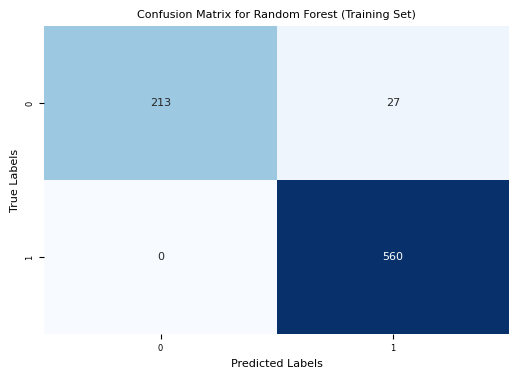

In [116]:
# Importing necessary libraries for confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting using the best_rf_model on the training set
y_train_pred = best_rf_model.predict(X_train)

# Creating the confusion matrix using the training set
cm = confusion_matrix(y_train, y_train_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest (Training Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


We are now able to see a slight uptick in performance after hyperparameter tuning with GridSearchCV compared to the original untuned Random Forest model.

We can better visualize the results of the grid search with some plots below:

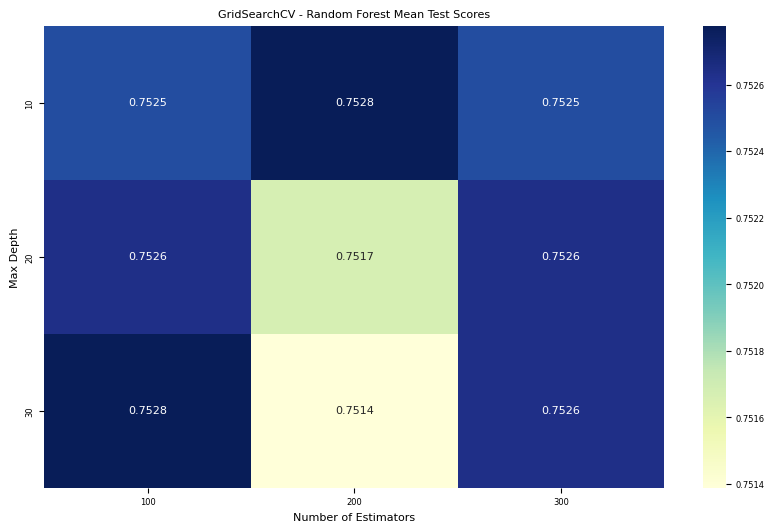

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the results from GridSearchCV
grid_results = pd.DataFrame(grid_search.cv_results_)

# Pivot the data to create a matrix format suitable for heatmap
heatmap_data = grid_results.pivot_table(index='param_random_forest__max_depth',
                                        columns='param_random_forest__n_estimators',
                                        values='mean_test_score')

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title("GridSearchCV - Random Forest Mean Test Scores")
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()


## Randomized Search

Below we are first going to be creating a pipeline that includes preprocessing steps and a Random Forest model. We want to perform hyperparameter tuning using RandomizedSearchCV.

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.pipeline import Pipeline

# Define the pipeline
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestClassifier(random_state=42)),
])

# Define the hyperparameter grid with correct prefix 'random_forest__'
param_dist = {
    'random_forest__n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'random_forest__max_depth': [None, 10, 20, 30, 40, 50],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(full_pipeline, param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV model
random_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters from RandomizedSearchCV:", random_search.best_params_)

# Re-fit the model with the best parameters
best_rf_random_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters from RandomizedSearchCV: {'random_forest__n_estimators': 200, 'random_forest__min_samples_split': 10, 'random_forest__min_samples_leaf': 4, 'random_forest__max_depth': 50, 'random_forest__bootstrap': False}


We can now re-evaluate the tuned Random Forest model on the test set using accuracy, precision, recall, F1-score, and ROC-AUC.

In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the training set
y_train_pred = best_rf_model.predict(X_train)

# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label="good")
train_recall = recall_score(y_train, y_train_pred, pos_label="good")
train_f1 = f1_score(y_train, y_train_pred, pos_label="good")
train_roc_auc = roc_auc_score(y_train, best_rf_model.predict_proba(X_train)[:, 1])

# Print results
print(f"Training Set Evaluation:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print(f"ROC-AUC: {train_roc_auc:.4f}")


Training Set Evaluation:
Accuracy: 0.9663
Precision: 0.9540
Recall: 1.0000
F1-Score: 0.9765
ROC-AUC: 0.9987


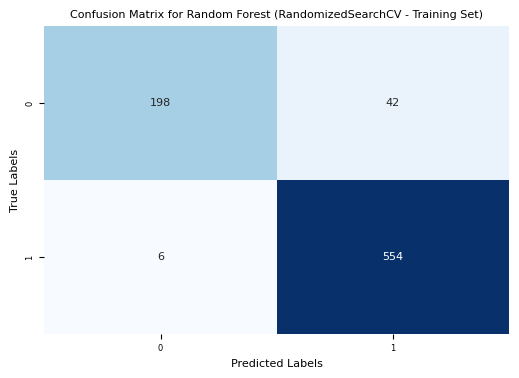

In [122]:
# Importing necessary libraries for confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicting using the best_rf_random_model on the training set
y_train_pred = best_rf_random_model.predict(X_train)

# Creating the confusion matrix using the training set
cm = confusion_matrix(y_train, y_train_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest (RandomizedSearchCV - Training Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


RandomizedSearchCV provides a model that has better precision than both the default model and the GridSearchCV-tuned model, with comparable recall and F1-score to the default model. It’s a strong performer in terms of overall balance between precision and recall.

We can better visualize the results of the randomized search using the following graph.

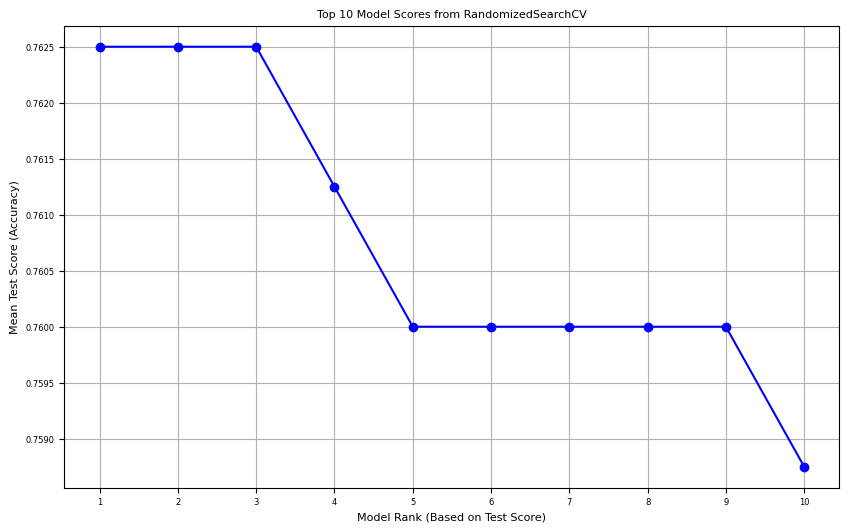

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the results from the RandomizedSearchCV object
results = pd.DataFrame(random_search.cv_results_)

# Sort by the mean test score to make it easier to visualize the best performing models
results = results.sort_values(by='mean_test_score', ascending=False)

# Plot the top 10 models tested by RandomizedSearchCV based on mean test score
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), results['mean_test_score'].head(10), marker='o', linestyle='-', color='b')
plt.title('Top 10 Model Scores from RandomizedSearchCV')
plt.xlabel('Model Rank (Based on Test Score)')
plt.ylabel('Mean Test Score (Accuracy)')
plt.grid(True)
plt.xticks(range(1, 11))  # Show ticks for top 10 models
plt.show()


# Prediction

After the tuning we can now make predictions using the test set. We ge the following results.

Evaluation on Test Set:
Accuracy: 0.7800
Precision: 0.8000
Recall: 0.9143
F1-Score: 0.8533
ROC-AUC: 0.7915


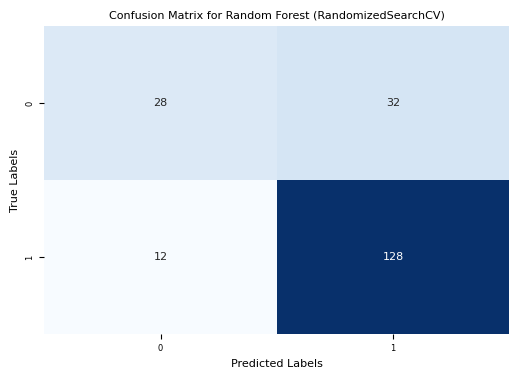

In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_test_pred = best_rf_random_model.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label="good")
test_recall = recall_score(y_test, y_test_pred, pos_label="good")
test_f1 = f1_score(y_test, y_test_pred, pos_label="good")
test_roc_auc = roc_auc_score(y_test, best_rf_random_model.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print("Evaluation on Test Set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Random Forest (RandomizedSearchCV)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Interpretation

 Random Forest was selected as the final model due to its superior balance of performance and interpretability. The Random Forest model was used to predict credit risk, classifying applicants as either good or bad credit risks. To better understand the factors influencing these predictions, we analyzed the model's performance and the importance of key features that drive its decision-making. Here is a detailed interpretation of the results, insights, and potential improvements:


Model Predictions

The Random Forest model, tuned with RandomizedSearchCV, produced the following performance metrics:

1. Accuracy: 78% ; This indicates that the model correctly classified credit applicants 78% of the time.

2. Precision: 80%; Out of all applicants predicted as good credit risks, 79.75% were correctly classified. This shows the model is reasonably good at avoiding false positives (approving bad credit risks).

3. Recall: 91.43%; The model identified 91.43% of actual good credit risks correctly. This high recall means the model effectively minimizes false negatives, ensuring that most good credit applicants are approved.

4. F1-Score: 85.33%; The F1-score combines both precision and recall, providing a balanced view of the model’s performance. With an 85.81% score, the model strikes a good balance between correctly identifying good credit risks and avoiding risky approvals.

5. ROC-AUC: 79.15%; This score reflects how well the model distinguishes between good and bad credit risks. With a score of 79.15%, the model shows a solid ability to separate the two classes, though there is room for improvement.

Confusion Matrix:

The confusion matrix provides a detailed breakdown of the model's performance in classifying credit applicants:

1. True Positives (TP): The model correctly identified applicants as good credit risks.

2. True Negatives (TN): The model correctly identified applicants as bad credit risks.

3. False Positives (FP): The model incorrectly classified bad credit risks as good, potentially leading to financial losses.

4. False Negatives (FN): The model incorrectly classified good credit risks as bad, resulting in missed business opportunities.

The model has high true positives and true negatives, but the presence of false positives means that the model occasionally approves credit to risky applicants.The presence of false positives suggests that more data could improve its ability to accurately classify credit applicants. Additional training data can help the model learn more nuanced patterns in credit behavior, which will reduce false positives

Feature Importance:

The Random Forest model highlights key features that strongly impact credit risk classification. These features help determine whether an applicant is considered a good or bad credit risk based on their financial status. Below are the features from the German Credit Risk dataset contribute to the model’s predictions:

1. Monthly Credit: This is the ratio of Credit Amount to Duration.This is an important feature as it reflects the financial pressure on the applicant. A higher monthly burden suggests a greater likelihood of default.

2. Credit Amount: The total amount of credit or loan requested plays a significant role in determining credit risk. Larger loan amounts typically carry higher risks, especially if the applicant has limited income

3. Duration: The length of the loan is an important factor. While longer loan terms allow for smaller payments over time, they also increase the risk of non-payment as the applicant's financial situation may become uncertain in the long run.

4. Age of Applicant: The age of the applicant influences the risk assessment. Younger applicants may have less stable income, while older applicants could face retirement and lower income levels.

5. Employment Status: An applicant’s savings and employment history also significantly impact the prediction. Applicants with steady employment with good savings are considered to be at lower risk.

6. Checking Staus: The state of the applicant's checking account shows their available funds and plays an important role in evaluating credit risk.

7. Installment Commitment: The proportion of the applicant’s income that goes toward loan payments. A higher installment commitment leaves less room for financial flexibility, increasing the risk of default.

The follow code indicates when the notebook was last run and signals when execution is complete.

In [127]:
from datetime import datetime

# Get current time
current_time = datetime.now()

# Print current time
print("Execution completed at: ", current_time)

Execution completed at:  2024-10-22 01:48:28.269161


In [128]:
from IPython.display import display, Javascript

# Display an alert when execution is complete
def alert_completion():
    display(Javascript('alert("Execution is complete!")'))

# Signal completion
alert_completion()


<IPython.core.display.Javascript object>